In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
from omegaconf import OmegaConf
import diffusion_gosai_update
import fm_dna
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
import dataloader_gosai
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import oracle
from scipy.stats import pearsonr
import torch
from tqdm import tqdm
import diffusion_gosai_cfg
import torch.nn.functional as F
from utils import set_seed
set_seed(0, use_cuda=True)
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

=> Seed of the run set to 0


In [2]:
base_path = '/home/ubuntu'

In [ ]:
# our model  
CKPT_PATH = os.path.join(base_path, 'finetune_models/fm_rollout.ckpt')
NUM_SAMPLE_BATCHES = 10
NUM_SAMPLES_PER_BATCH = 64

In [4]:
# reinitialize Hydra
GlobalHydra.instance().clear()

# Initialize Hydra and compose the configuration|
initialize(config_path="configs_gosai", job_name="load_model")
cfg = compose(config_name="config_gosai.yaml")
cfg.eval.checkpoint_path = CKPT_PATH

/tmp/ipykernel_1580/1132405131.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs_gosai", job_name="load_model")


In [5]:
model = fm_dna.DiscreteFlowMatchingNet(cfg).cuda() 
model.load_state_dict(torch.load(cfg.eval.checkpoint_path))
model.eval()

DiscreteFlowMatchingNet(
  (model): ConvNet(
    (input_projection): Embedding(5, 128)
    (embed_timestep): Sequential(
      (0): Embedding(1024, 128)
      (1): Unsqueeze()
    )
    (blocks): ModuleList(
      (0-5): 6 x Sequential(
        (0): Transpose()
        (1): Conv1d(128, 128, kernel_size=(31,), stride=(1,), padding=same)
        (2): Transpose()
        (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (4): GELU(approximate='none')
        (5): Linear(in_features=128, out_features=128, bias=True)
        (6): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (7): GELU(approximate='none')
      )
    )
    (timestep_embedding_norms): ModuleList(
      (0-5): 6 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (output_projection): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [ ]:
old_path = os.path.join(base_path, 'pretrained_models/pretrained_fm.ckpt')
ckpt = torch.load(old_path, map_location="cuda")
old_model = fm_dna.DiscreteFlowMatchingNet(cfg).cuda() 
old_model.load_state_dict(ckpt, strict=False)  
old_model.eval()

DiscreteFlowMatchingNet(
  (model): ConvNet(
    (input_projection): Embedding(5, 128)
    (embed_timestep): Sequential(
      (0): Embedding(1024, 128)
      (1): Unsqueeze()
    )
    (blocks): ModuleList(
      (0-5): 6 x Sequential(
        (0): Transpose()
        (1): Conv1d(128, 128, kernel_size=(31,), stride=(1,), padding=same)
        (2): Transpose()
        (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (4): GELU(approximate='none')
        (5): Linear(in_features=128, out_features=128, bias=True)
        (6): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (7): GELU(approximate='none')
      )
    )
    (timestep_embedding_norms): ModuleList(
      (0-5): 6 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (output_projection): Linear(in_features=128, out_features=5, bias=True)
  )
)

### Sample from the generative model

In [9]:
all_detoeknized_samples = []
all_raw_samples = []
_, val_loader, _ = dataloader_gosai.get_dataloaders_gosai(cfg)
batch = next(iter(val_loader))
seqs = batch["seqs"].cuda()
B, L = seqs.shape
step = 32

for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    generator, logits = model.sample(
        num_sampling_steps = 8,
        num_samples =  B,
        sequence_length = L,
        yield_intermediate=True,
    )

    for x_t in generator:
        samples = x_t 

    y_soft = F.softmax(logits / cfg.gumbel_temp, dim=-1)
    idx = y_soft.argmax(dim=-1)
    y_hard = F.one_hot(idx, 4).float()
    samples = y_hard.detach() - y_soft.detach() + y_soft
    samples = torch.argmax(samples, dim = -1)
    
    all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    all_detoeknized_samples.extend(detokenized_samples)
all_raw_samples = torch.concat(all_raw_samples)
all_raw_samples = F.one_hot(all_raw_samples, num_classes=4)

[debug] Using GosaiDataset defined in: /home/ubuntu/drakes_single/dataloader_gosai.py


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


In [13]:

old_all_detoeknized_samples = []
old_all_raw_samples = []

_, val_loader, _ = dataloader_gosai.get_dataloaders_gosai(cfg)
batch = next(iter(val_loader))
seqs = batch["seqs"].cuda()
B, L = seqs.shape
step = 32

for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    generator, logits = old_model.sample(
        num_sampling_steps = 8,
        num_samples =  B,
        sequence_length = L,
        yield_intermediate=True,
    )
    samples = generator
    for x_t in generator:
        samples = x_t 

    y_soft = F.softmax(logits / cfg.gumbel_temp, dim=-1)
    idx = y_soft.argmax(dim=-1)
    y_hard = F.one_hot(idx, 4).float()
    samples = y_hard.detach() - y_soft.detach() + y_soft
    samples = torch.argmax(samples, dim = -1)
    old_all_raw_samples.append(samples)

    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    old_all_detoeknized_samples.extend(detokenized_samples)
old_all_raw_samples = torch.concat(old_all_raw_samples)
old_all_raw_samples = F.one_hot(old_all_raw_samples, num_classes=4)


[debug] Using GosaiDataset defined in: /home/ubuntu/drakes_single/dataloader_gosai.py


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.13it/s]


In [19]:
config=OmegaConf.to_container(cfg, resolve=False)
highexp_kmers_99, n_highexp_kmers_99, highexp_kmers_999, n_highexp_kmers_999, highexp_set_sp_clss_999, highexp_preds_999, highexp_seqs_999 = oracle.cal_highexp_kmers(return_clss=True,config = cfg)

[debug] Using GosaiDataset defined in: /home/ubuntu/drakes_single/dataloader_gosai.py


wandb: Currently logged in as: h42294865 (h42294865-individual) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.5 (614.5MB/s)


### Pred-Activity based on Eval Oracle

In [ ]:
# Calculate the predictions of the oracle model on the generated sequences
generated_preds = oracle.cal_gosai_pred_new(all_detoeknized_samples, mode='eval')
old_generated_preds = oracle.cal_gosai_pred_new(old_all_detoeknized_samples, mode='eval')
if all_detoeknized_samples == old_all_detoeknized_samples:
    print("Yes")

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0 (984.3MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9 (1004.5MB/s)


In [ ]:
compare = np.concatenate((generated_preds[:,0],old_generated_preds[:,0]), axis = 0) 

In [22]:
np.median(compare.reshape(-1, 80), axis=-1)

array([6.7994943, 4.1422067], dtype=float32)

### ATAC-Acc

In [ ]:
generated_preds_atac = oracle.cal_atac_pred_new(all_detoeknized_samples)
old_generated_preds_atac = oracle.cal_atac_pred_new(old_all_detoeknized_samples)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0 (984.5MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0 (902.1MB/s)


In [ ]:
compare = np.concatenate((generated_preds_atac[:,1], old_generated_preds_atac[:,1]), axis = 0) 

In [25]:
(old_generated_preds_atac[:,1]>0.5).sum()/80 #640

np.float64(0.0)

In [26]:
(generated_preds_atac[:,1]>0.5).sum()/80  #640

np.float64(0.9625)

### 3-mer Pearson Correlation

In [32]:
def compare_kmer(kmer1, kmer2, n_sp1, n_sp2, title):
    kmer_set = set(kmer1.keys()) | set(kmer2.keys())
    counts = np.zeros((len(kmer_set), 2))
    for i, kmer in enumerate(kmer_set):
        if kmer in kmer1:
            counts[i][1] = kmer1[kmer] * n_sp2 / n_sp1
        if kmer in kmer2:
            counts[i][0] = kmer2[kmer]
            
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.scatter(counts[:, 0], counts[:, 1], alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("k-mer train top 0.1% count")
    ax.set_ylabel("k-mer generated count")
    ax.set_ylim((-5, np.max(counts) + 5))
    ax.set_xlim((-5, np.max(counts) + 5))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.text(0.5, 0.5, f"Pearson Corr: {pearsonr(counts[:, 0], counts[:, 1])[0]:.3f}")
    plt.show()

    print(pearsonr(counts[:, 0], counts[:, 1]))

In [ ]:
generated_kmer = oracle.count_kmers(all_detoeknized_samples)
old_generated_kmer = oracle.count_kmers(old_all_detoeknized_samples)

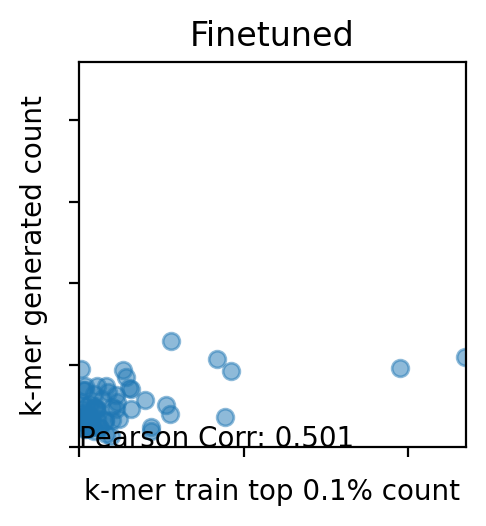

PearsonRResult(statistic=np.float64(0.501463380390028), pvalue=np.float64(2.4322387112455442e-05))


In [34]:
compare_kmer(highexp_kmers_999, generated_kmer, n_highexp_kmers_999, len(all_detoeknized_samples), title=r"Finetuned")

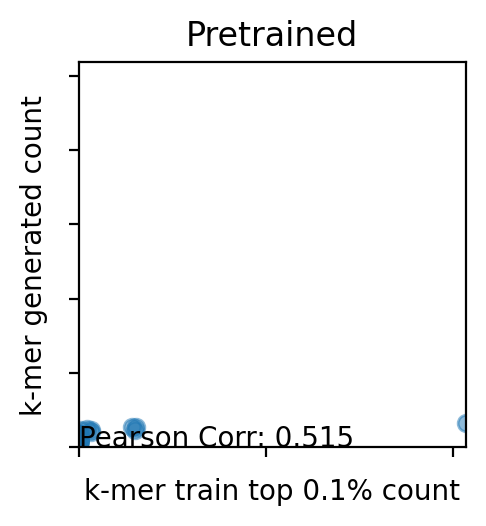

PearsonRResult(statistic=np.float64(0.5154568644605428), pvalue=np.float64(1.3087222846582882e-05))


In [35]:
compare_kmer(highexp_kmers_999, old_generated_kmer, n_highexp_kmers_999, len(old_all_detoeknized_samples), title=r"Pretrained")

### JASPER Motif Analysis

In [ ]:
from grelu.interpret.motifs import scan_sequences
from grelu.io.motifs import get_jaspar
motifs = get_jaspar(
    release='JASPAR2024',    
    collection='CORE',        
    tax_group='vertebrates',        
)
motif_count = scan_sequences(all_detoeknized_samples, motifs=motifs, pthresh=1e-4, rc=True)


/home/ubuntu/myenv/lib/python3.10/site-packages/memelite/fimo.py:406: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hits = pandas.concat(hits)


In [ ]:
motif_count = scan_sequences(all_detoeknized_samples, motifs=motifs, pthresh=1e-4, rc=True)
print(motif_count)
motif_count_sum = motif_count['motif'].value_counts()
motif_count_old = scan_sequences(old_all_detoeknized_samples, motifs = motifs, pthresh = 1e-4, rc = True)
motif_count_old_sum = motif_count_old['motif'].value_counts()
motif_count_top = scan_sequences(highexp_seqs_999, motifs=motifs, pthresh=1e-4, rc=True)
motif_count_top_sum = motif_count_top['motif'].value_counts()

/home/ubuntu/myenv/lib/python3.10/site-packages/memelite/fimo.py:406: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hits = pandas.concat(hits)


                   motif sequence  seq_idx start  end strand      score  \
0          MA0472.2_EGR2        0        0     8   19      -   9.750974   
1          MA2094.1_PAX8        0        0   150  166      -  10.555917   
2           MA0516.3_SP2        0        0   150  159      +  10.663006   
3         MA0742.2_KLF12        0        0   150  159      +  11.363924   
4     MA0006.2_Ahr::Arnt        0        0     9   14      +   9.816539   
...                  ...      ...      ...   ...  ...    ...        ...   
3613     MA1650.2_ZBTB14        9        9   145  153      +  12.109123   
3614     MA1713.2_ZNF610        9        9    60   70      -  17.467789   
3615      MA1721.2_ZNF93        9        9    10   24      +  15.201548   
3616      MA1721.2_ZNF93        9        9    62   76      +   9.512226   
3617    MA1602.2_ZSCAN29        9        9   153  164      -  12.848443   

           p-value       matched_seq  
0     7.987022e-05       AGCGTGGGAGC  
1     4.715822e-05  T

/home/ubuntu/myenv/lib/python3.10/site-packages/memelite/fimo.py:406: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hits = pandas.concat(hits)
/home/ubuntu/myenv/lib/python3.10/site-packages/memelite/fimo.py:406: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hits = pandas.concat(hits)


In [ ]:
motifs_summary = pd.concat(
    [motif_count_top_sum, motif_count_sum, motif_count_old_sum], axis=1) 
motifs_summary.columns = ['top_data', 'finetuned', 'pretrained']
motifs_summary.corr(method='spearman')


,top_data,finetuned,pretrained
top_data,1.000000,0.427313,0.641800
finetuned,0.427313,1.000000,0.383022
pretrained,0.641800,0.383022,1.000000
